In [58]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image
%matplotlib inline

In [59]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

In [75]:
def preprocess_image(image_path):
    """
    Loads image from path and preprocesses it.
    
    Parameter image_path: Path to image file
    Precondition: path is a string
    """
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    """
    Scales down images using nearest neighbor downsampling.

    Parameter image: 3D of 4D tensor of preprocessed image
    Precondition: image is a tensor
    """
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(tf.cast(image, tf.uint8))

    lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4]))
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

def plot_image(image, title=""):
    """
    Plots images from image tensors.
    
    Parameter image: a 3D image tensor
    Precondition: image is in the format [height, width, channels]
    
    Parameter title: Title to display in the plot
    Precondition: title is a string
    """
    image = np.asarray(image)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

In [61]:
IMAGE_PATH = '../../GOES_Files/png_files/OR_ABI-L1b-RadC-M3Cdiff_G17_s20183180507189_e20183180509573_c20183180510006.png'

In [172]:
hr_image = preprocess_image(IMAGE_PATH)
print(hr_image.shape)
lr_image = downscale_image(tf.squeeze(hr_image))
print(lr_image.shape)
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print(fake_image.shape)

(1, 500, 500, 3)
(1, 125, 125, 3)
(500, 500, 3)


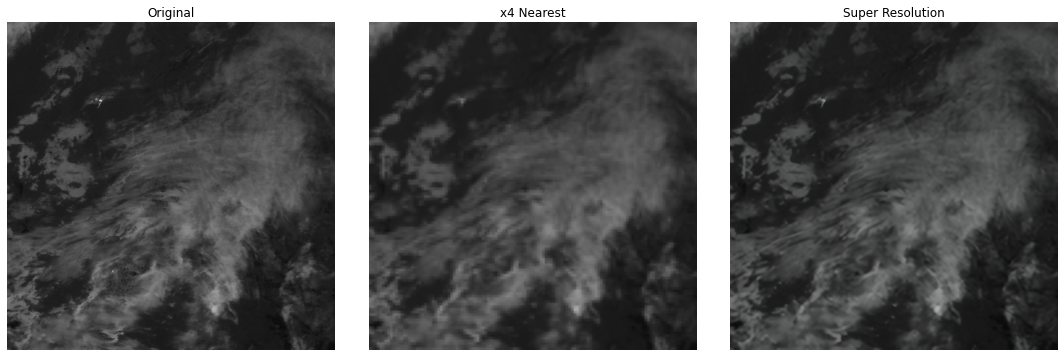

In [78]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Nearest")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")